In [9]:
import cv2 as cv
import numpy as np
from PIL import Image, ImageOps, ImageDraw
from pathlib import Path
import matplotlib.pyplot as plt
import math

# Choose an example file (200dpi)
(Journal)

ce_001sg.bmp;4;748;1882;TXT

ce_001sg.bmp;4;1427;2059;TXT

ce_001sg.bmp;5;1468;142;TXT

ce_001sg.bmp;5;1551;389;TXT


ce_001z4 file contents: 

�Ե�ԡ�����С��
�͢ͺ��Фس��ŹԸԪ�¾Ѳ�ҷ�������ʹѺʹع��������
���͢�����  �͢ͺ�س�ͧ�ع��������������͹��ѡ���ѧ�ҹ  ��ǹ�Ҫ

In [25]:
img_path = "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TestSet/Journal/Image/200dpi_BW/ce_001sb.bmp"
img = Image.open(img_path)

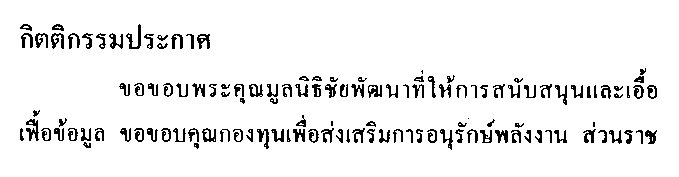

In [26]:
z4 = img.crop((748, 1882, 1427, 2059))
z4

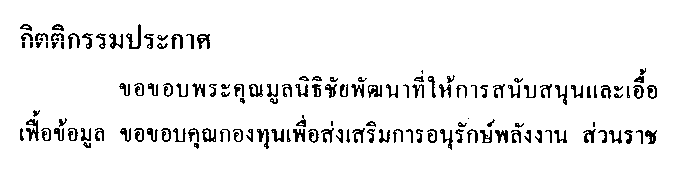

In [24]:
draw = ImageDraw.Draw(z4.convert("RGBA"), "RGBA")
draw.rectangle((xr, yr-14, xr+wr, yr+hr+10))
display(draw._image)

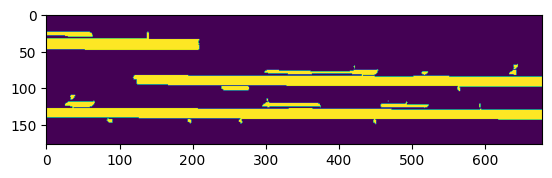

In [4]:
# Split into rectangles
# https://stackoverflow.com/questions/63596796/sorting-contours-based-on-precedence-in-python-opencv/63662498#63662498
kernel = cv.getStructuringElement(cv.MORPH_RECT, (51,1))
morph = cv.morphologyEx(np.array(z4), cv.MORPH_CLOSE, kernel)

plt.imshow(morph)

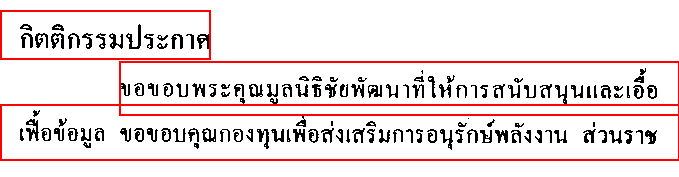

In [35]:
# Get bounding boxes
rowcontours = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
rowcontours = rowcontours[0] if len(rowcontours) == 2 else rowcontours[1]

draw = ImageDraw.Draw(z4.convert("RGBA"), "RGBA")

rows = [] 

# draw.rectangle(((280, 10), (1010, 706)), fill=(200, 100, 0, 127))

for rowcntr in rowcontours:
    xr,yr,wr,hr = cv.boundingRect(rowcntr)

    if hr > 15:
        draw.rectangle((xr, yr-14, xr+wr, yr+hr+10), outline= "Red", fill= None, width = 2)
        rows.append((xr, yr-14, xr+wr, yr+hr+10))
        # display(z4.crop((xr, yr, xr+wr, yr+hr)))

# Sort the rows
rows.sort(key=lambda x: x[1])

# for row in rows:
#     display(z4.crop(row))
display(draw._image)

In [15]:
contours, _ = cv.findContours(np.array(z4), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print(len(contours))

220


In [19]:
bounding_boxes = [] 

for cnt in contours:
    x, y, w, h = cv.boundingRect(cnt)
    if w > 5 and h > 10:
        bounding_boxes.append((x, y-50, x+w, y+h+20))

# Sort by Euclidian distance
# This doesn't work very well so need to find a better method
# Maybe split text into rows then segment out
sorted_boxes = sorted(bounding_boxes,key=lambda pt:math.sqrt(pt[0]**2+pt[1]**2))

for (x, y, x2, y2) in sorted_boxes[:10]:
    display(z4.crop((x, y, x2, y2)))

# Second example file, higher DPI

ce_001tg.bmp;2;397;212;TXT

ce_001tg.bmp;2;1385;2690;TXT


5.  �ŷ��Ҵ��Ҩ����Ѻ
���ͧ�ҡ��鹷����Թ����ç�����ǹ�˭�����  �ٹ���֡�ҡ��
�Ѳ���ѹ���ͧ�Ҩҡ����Ҫ����  ��觷ء� �� ������ٹ��� �ջ�ЪҪ�
�ɵá�  �ѡ�Ԩ��  �ѡ��áԨ  �ѡ�ص��ˡ���  �ѡ���¹  ���Ե  �ѡ�֡��
���  ������������ٹ���  �����������蹤�  ��觶������繾ԾԸ�ѳ������

(Which seems way too short for the given image...)

In [ ]:
img_path = "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TestSet/Journal/Image/300dpi_BW/ce_001tb.bmp"
img = Image.open(img_path)

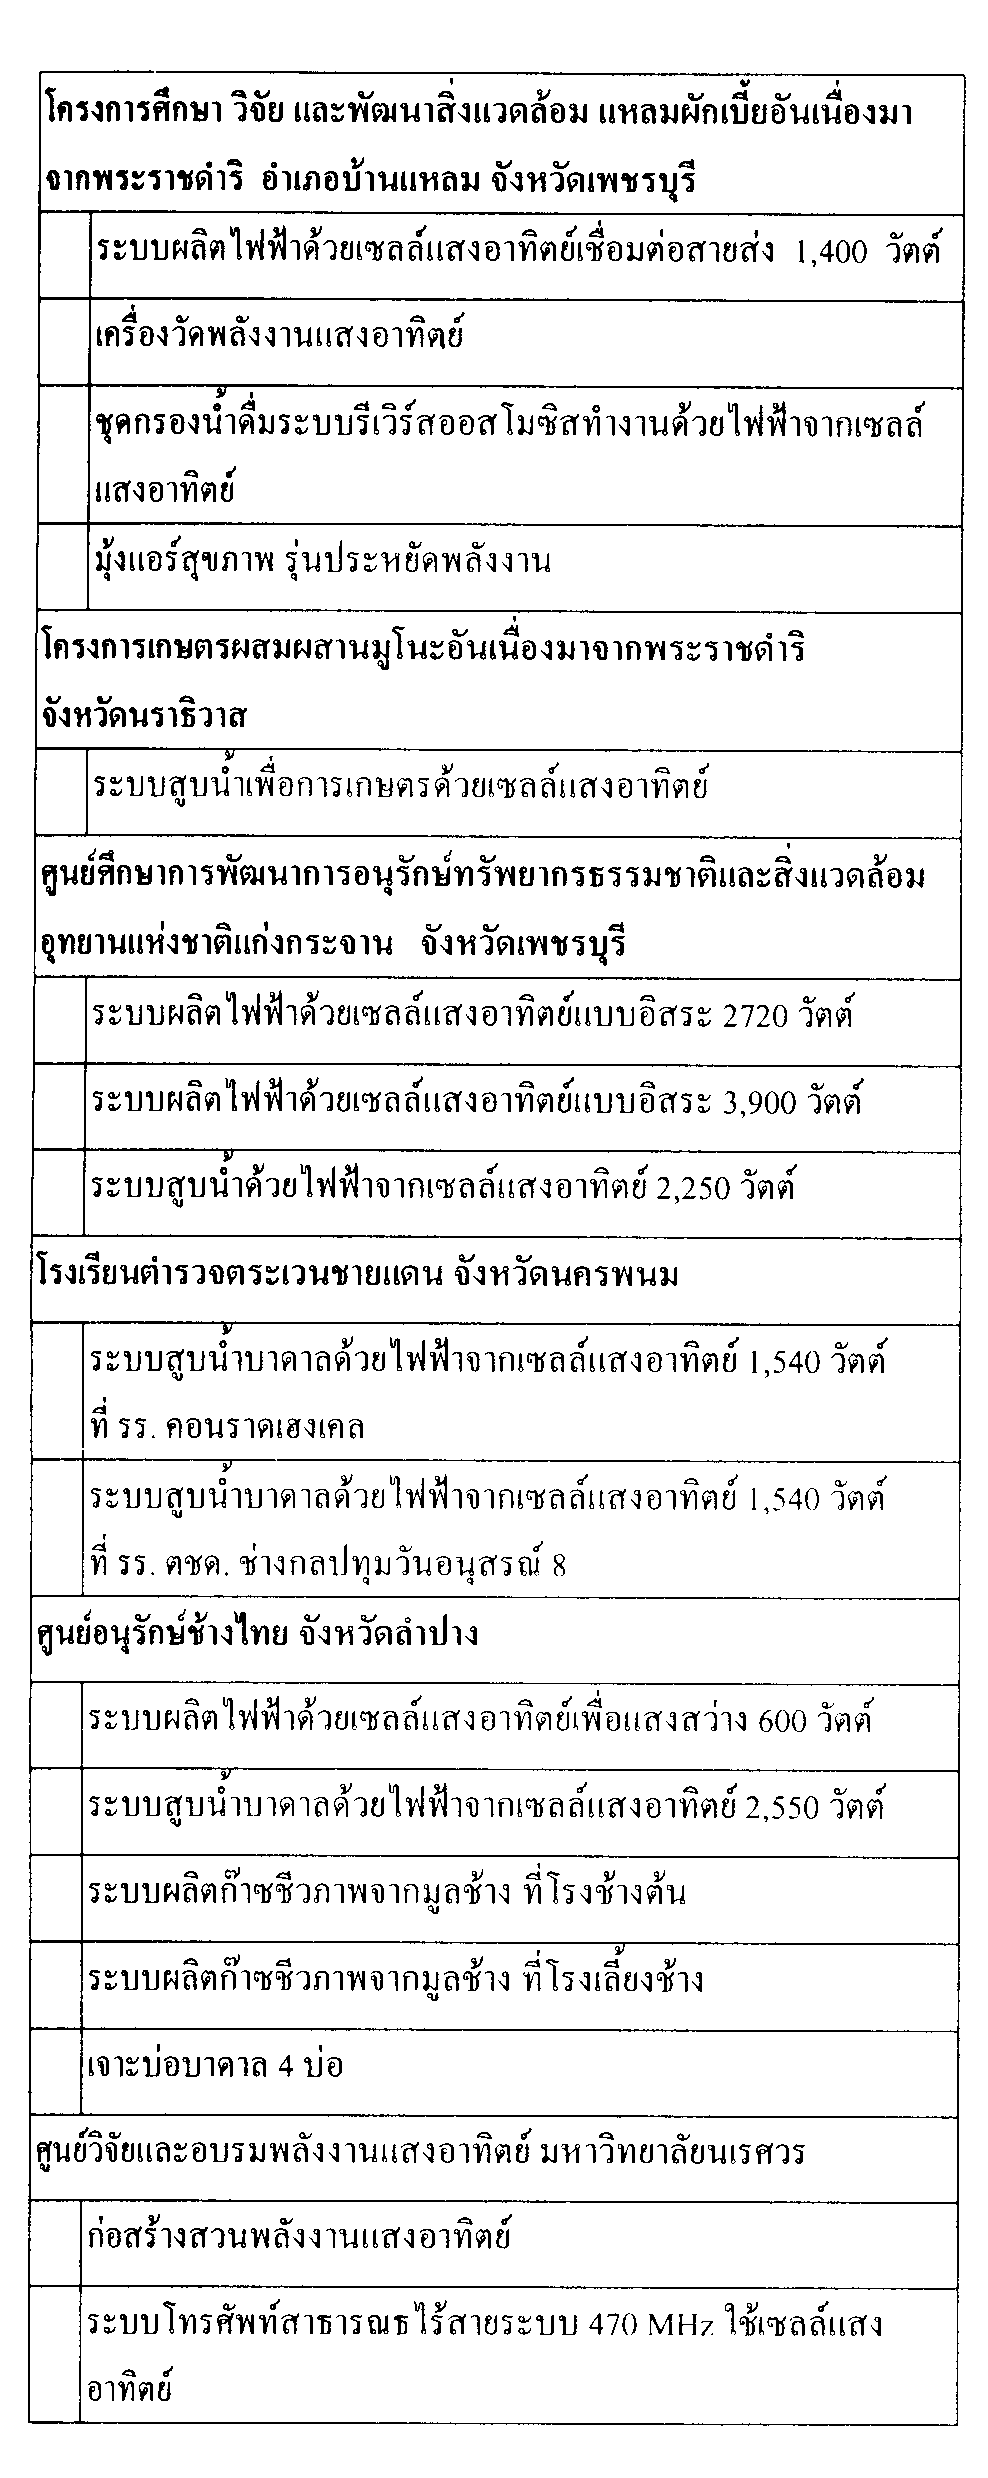

In [36]:
z2 = img.crop((397, 212, 1385, 2690))
z2

In [ ]:
contours, _ = cv.findContours(np.array(z2), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print(len(contours))

In [35]:
for cnt in contours[:10]:
    x, y, w, h = cv.boundingRect(cnt)
    if w > 5 and h > 10:
        print(x, y, w, h)
        crop = z4.crop((x, y, x + w, y + h))
        display(crop)

645 130 12 14


636 130 7 14


624 130 9 14


# Write final function

In [155]:

def get_characters_from_image(img, plot_img=False):
    # Split into lines
    # Some ideas borrowed from this StackOverflow comment but I've done manual tweaking of parameters:
    # https://stackoverflow.com/questions/63596796/sorting-contours-based-on-precedence-in-python-opencv/63662498#63662498
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (30, 1))
    morph = cv.morphologyEx(np.array(img), cv.MORPH_CLOSE, kernel)

    rowcontours, _ = cv.findContours(morph, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    rows = []

    # For drawing
    draw_rect = ImageDraw.Draw(img.convert("RGBA"), "RGBA")
    draw_char = ImageDraw.Draw(img.convert("RGBA"), "RGBA")

    for rowcntr in rowcontours:
        xr, yr, wr, hr = cv.boundingRect(rowcntr)
        # Choose rows that have:
        # Ratio of weight/height >= 4
        # Height larger than a single character... but not too large
        if (wr / hr) >= 4 and hr > 15 and hr < 200:
            # Add a bit of flex space around the border
            borders = (xr, yr - 14, xr + wr + 10, yr + hr)
            draw_rect.rectangle(borders, outline="Red", fill=None, width=2)
            rows.append(borders)

    # Sort the rows by their y-coordinate
    rows.sort(key=lambda x: x[1])

    characters = []
    for row in rows:
        row_img = img.crop(row)
        contours, _ = cv.findContours(
            np.array(row_img), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE
        )
        bounding_boxes = []

        for cnt in contours:
            x, y, w, h = cv.boundingRect(cnt)
            if w > 2 and h > 3 and w < 100:
                y_add_below = 5
                y_add_above = 10
                borders = (x, y - y_add_above, x + w, y + h + y_add_below)
                crop_borders = (x + row[0], y + row[1] - y_add_above, x+row[0] + w, y + row[1] + h + y_add_below)
                draw_char.rectangle(crop_borders, outline="Blue", fill=None, width=2)
                bounding_boxes.append(borders)
        # Sort the characters by their x-coordinate
        bounding_boxes.sort(key=lambda x: x[0])
        characters.extend([row_img.crop(b) for b in bounding_boxes])

    if plot_img:
        fig, axs = plt.subplots(2, 2, figsize=(20, 20))
        axs[0][0].set_title("Original image")
        axs[0][1].set_title("With rectangles to separate lines")
        axs[1][0].set_title("Identified lines")
        axs[1][1].set_title("Identified characters")

        axs[0][0].imshow(img)
        axs[0][1].imshow(morph)
        axs[1][0].imshow(draw_rect._image)
        axs[1][1].imshow(draw_char._image)

        plt.tight_layout()

        fig.show()

    return characters

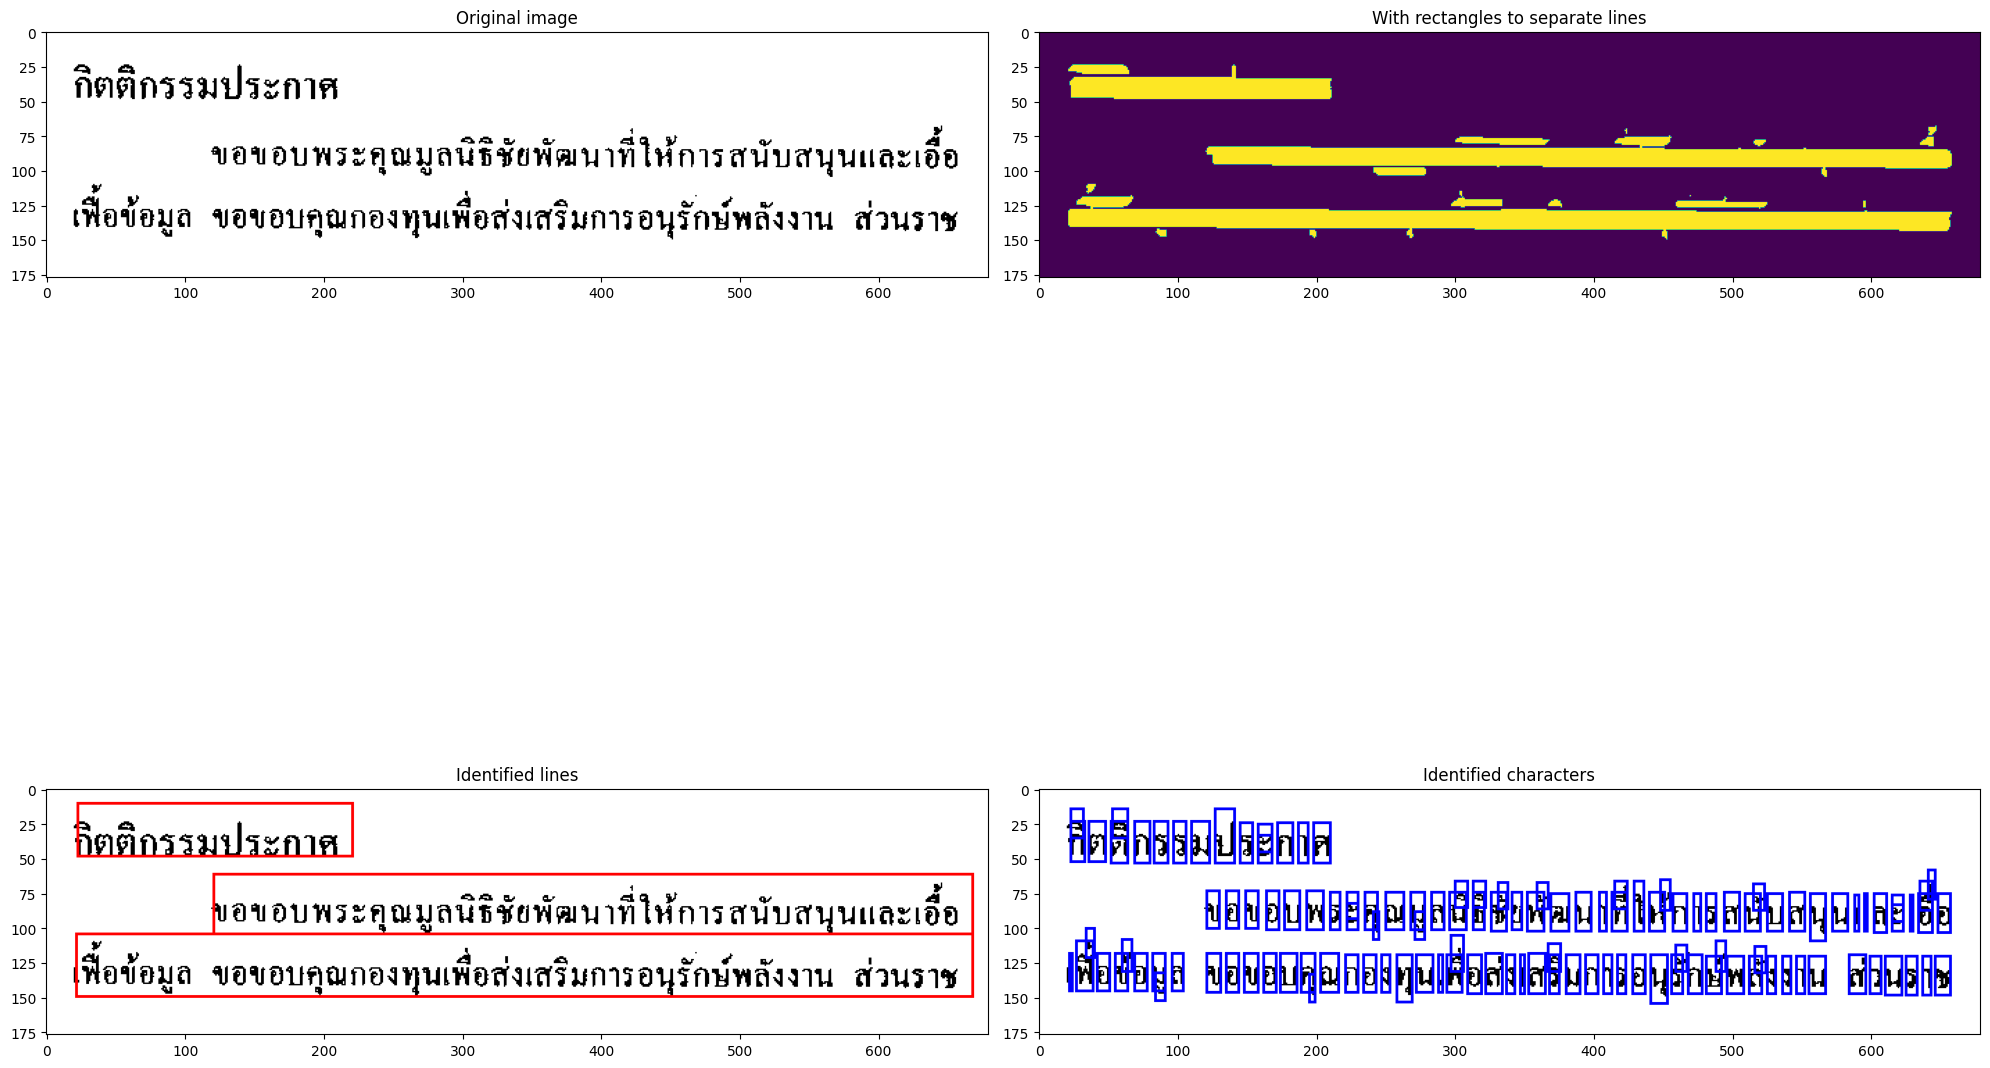

In [156]:
img_path = "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TestSet/Journal/Image/200dpi_BW/ce_001sb.bmp"
img = Image.open(img_path)
z4 = img.crop((748, 1882, 1427, 2059))
chars = get_characters_from_image(z4, plot_img=True)

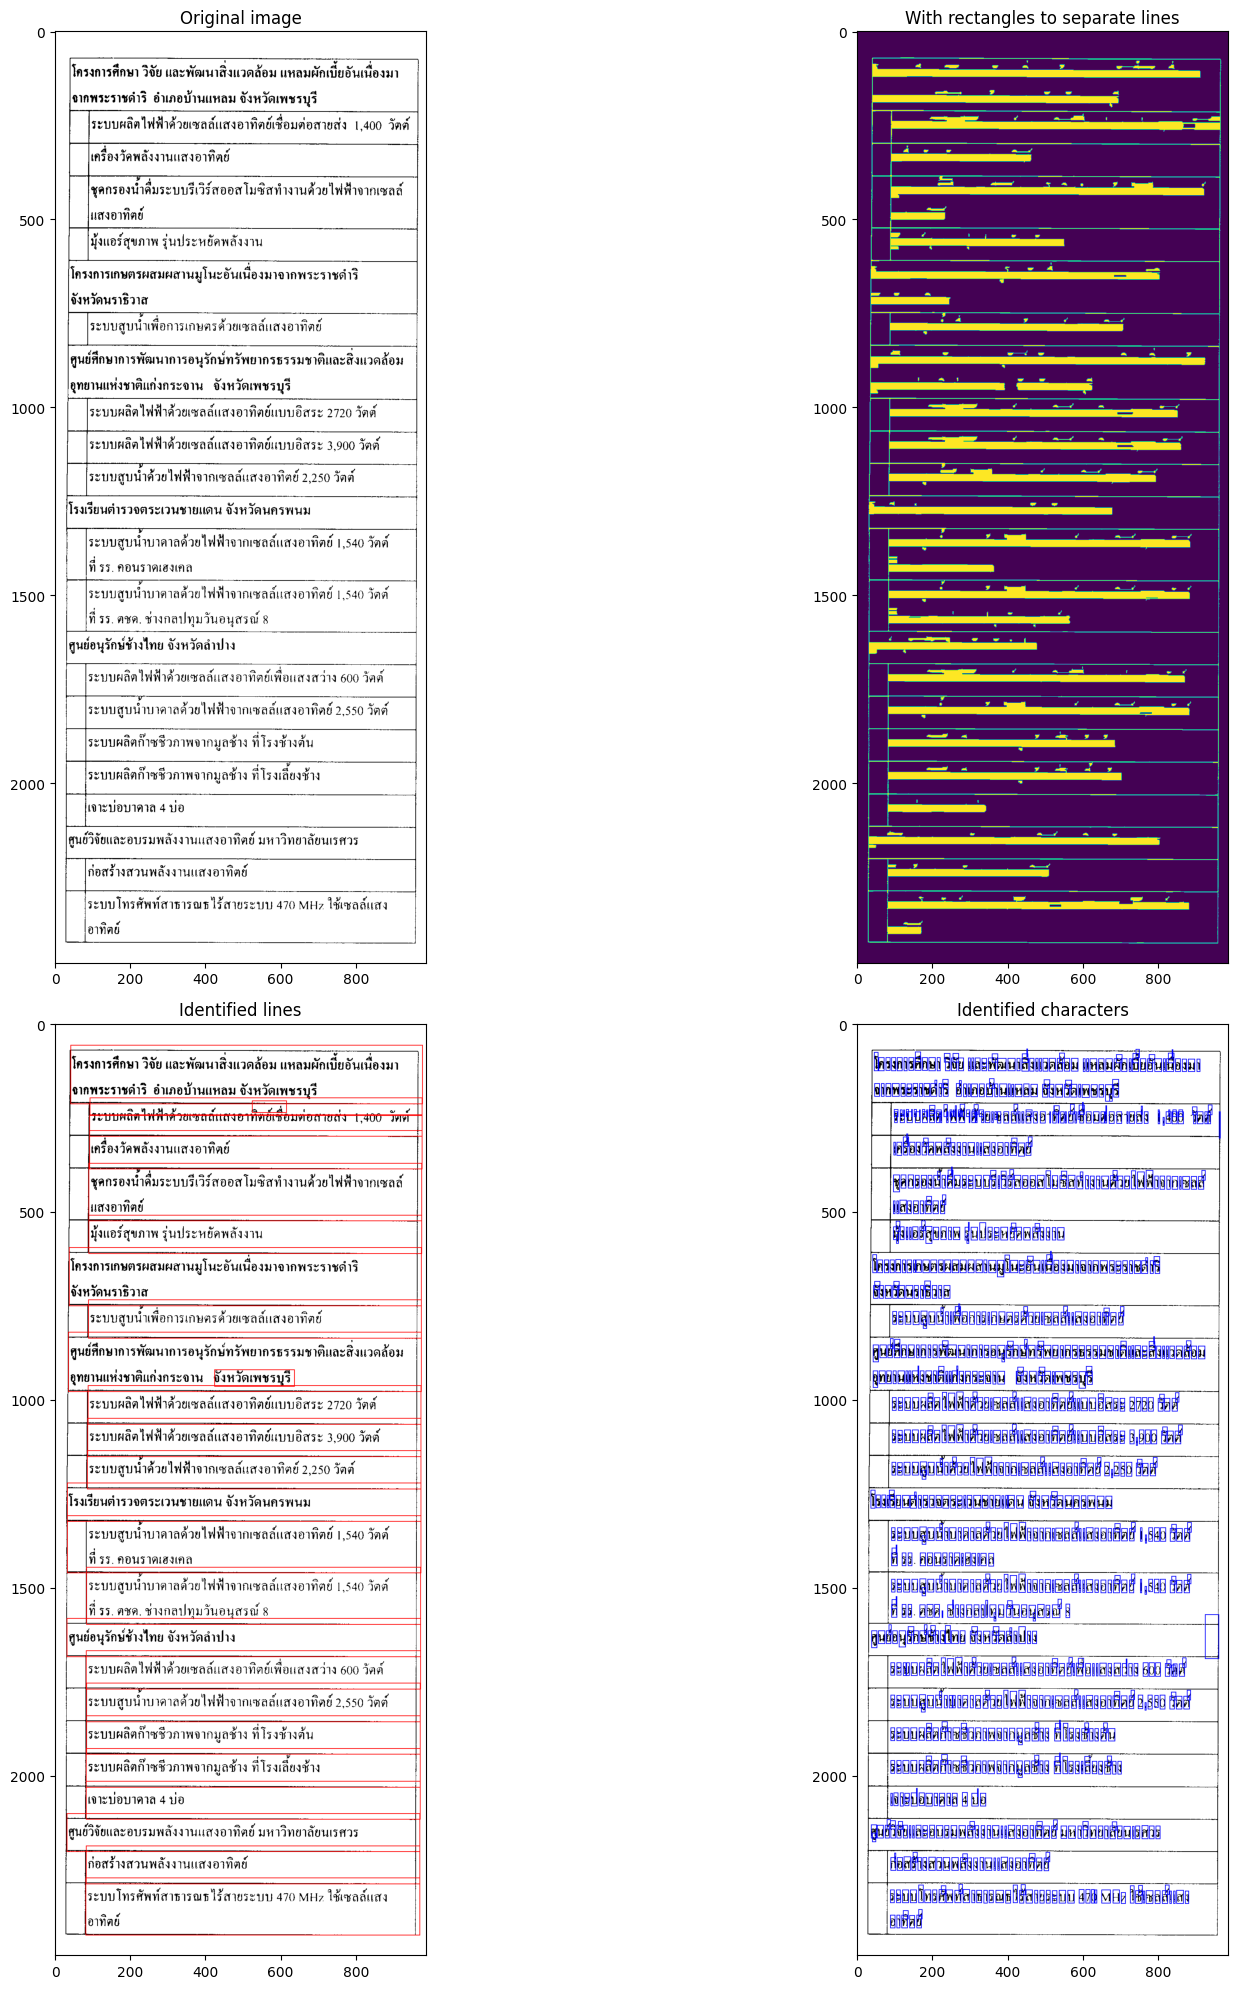

In [157]:
img_path = "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TestSet/Journal/Image/300dpi_BW/ce_001tb.bmp"
img = Image.open(img_path)
z2 = img.crop((397, 212, 1385, 2690))
chars = get_characters_from_image(z2, plot_img=True)